<a href="https://colab.research.google.com/github/safdark/Automata-Capstone/blob/CarND-Object-Detection-Lab/object-detection-coco/CarND-Object-Detection-Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CarND Object Detection Lab

Let's get started!

In [1]:
! rm -r Object-detection-coco
! git clone https://github.com/bessszilard/Object-detection-coco
! git clone https://github.com/marcomarasca/CarND-Traffic-Light-Detection.git

Cloning into 'Object-detection-coco'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 87 (delta 8), reused 80 (delta 5), pack-reused 0
Unpacking objects: 100% (87/87), done.
fatal: destination path 'CarND-Traffic-Light-Detection' already exists and is not an empty directory.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

## Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the latest pretrained models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), although do note that you may need a newer version of TensorFlow (such as v1.8) in order to use the newest models.

We are providing the download links for the below noted files to ensure compatibility between the included environment file and the models.

[SSD_Mobilenet 11.6.17 version](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz)

[RFCN_ResNet101 11.6.17 version](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz)

[Faster_RCNN_Inception_ResNet 11.6.17 version](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz)

Make sure to extract these files prior to continuing!

In [5]:
! cd Object-detection-coco/; ls

assets				  exercise-solutions
CarND-Object-Detection-Lab.ipynb  LICENSE
driving.mp4			  README.md
env_cn.yml			  ssd_mobilenet_v1_coco_11_06_2017
environment.yml			  tf_images


Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [6]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
#         print(color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

('Number of colors =', 148)


Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [0]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
# SSD_GRAPH_FILE = 'Object-detection-coco/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
# SSD_GRAPH_FILE = 'CarND-Traffic-Light-Detection/saved_models/converted/ssd_mobilenet_v1/frozen_inference_graph.pb'
SSD_GRAPH_FILE = 'CarND-Traffic-Light-Detection/saved_models/converted/ssd_mobilenet_v2/frozen_inference_graph.pb'
# RFCN_GRAPH_FILE = 'rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
# RFCN_GRAPH_FILE = 'CarND-Traffic-Light-Detection/saved_models/converted/'#rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'CarND-Traffic-Light-Detection/saved_models/converted/extra_faster_rcnn_inception_v2/frozen_inference_graph.pb' # faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'

In [0]:
# detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

In [0]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://www.petmd.com/sites/default/files/over-active-dog-211592482.jpg')
img = Image.open(BytesIO(response.content))

Run detection and classification on a sample image.

(1, 600, 800, 3)


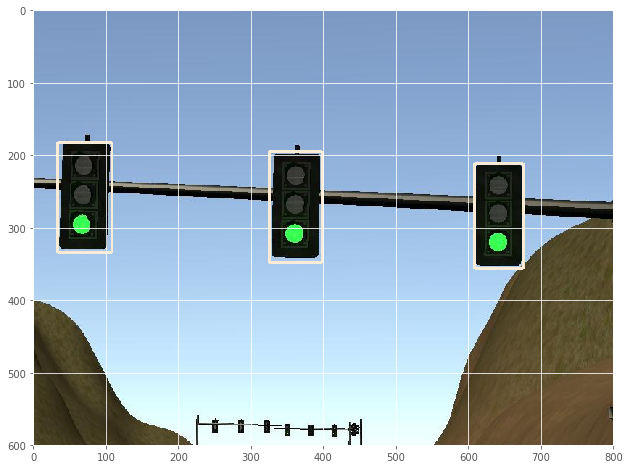

In [10]:
# Load a sample image.
# image = Image.open('./assets/sample1.jpg')
# image = Image.open('Object-detection-coco/assets/sample1.jpg')
image = Image.open('Object-detection-coco/tf_images/green-584.jpeg')
# image = img
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
print(image_np.shape)
with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.7
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image) 

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [0]:
lights_labels = { 1: 'green', 2: 'yellow', 3: 'red'}
# lights_labels[3]

In [12]:
import glob
from pylab import *
%matplotlib inline
import os

def pipeline(image):
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    with tf.Session(graph=detection_graph) as sess:                
        # Actual detection.
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                            feed_dict={image_tensor: image_np})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        confidence_cutoff = 0.7
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)

        # Each class with be represented by a differently colored box
        draw_boxes(image, box_coords, classes)
        return(image, classes) 

    
image_file_names = glob.glob('Object-detection-coco/tf_images/green-*.jpeg')
image_file_names = image_file_names +  glob.glob('Object-detection-coco/tf_images/red-*.jpeg')
image_file_names  = image_file_names + glob.glob('Object-detection-coco/tf_images/yellow-*.jpeg')

# print(image_file_names)

# for i in range(row):
#     image_file = image_file_names[i]
#     image = Image.open(image_file_names[i])
#     image = pipeline(image)
    
#     plt.figure(figsize=(12, 8))
#     plt.imshow(image)

rows = int(len(image_file_names) / 3)
cols = 3

missed = 0
# f, ax = subplots(rows, cols, figsize=(10, 50))
for i in range(rows):
    for j in range(cols):
        if i * cols + j < len(image_file_names):
            image_file = image_file_names[i * cols + j]
            file_no_path = os.path.split(image_file)[-1]
            light = file_no_path.split('-')[0]

            image = Image.open(image_file)
            image, classes = pipeline(image)
            
            if len(classes) == 0:
                missed += 1
                print("{} missed".format(light))
            elif lights_labels[classes[0]] != light:
                missed += 1
                print("{} != {}".format(light, lights_labels[classes[0]]))
            else:
                print("{} == {}".format(light, lights_labels[classes[0]]))

#             ax[i][j].imshow(image)
#             ax[i][j].set_title(classes) # image_file_names[i])
#             ax[i][j].axis('off')

#     plt.figure(figsize=(12, 8))
#     plt.imshow(image)

print("{} \tacc: {}".format(missed, double(len(image_file_names) - missed) / len(image_file_names)))

green missed
green == green
green == green
green == green
green == green
green == green
green == green
green == green
green == green
green == green
green missed
red == red
red == red
red == red
red == red
red == red
red == red
red == red
red == red
red == red
red == red
red == red
red missed
red == red
red == red
red == red
red == red
red == red
red == red
yellow == yellow
yellow == yellow
yellow missed
yellow missed
yellow missed
yellow == yellow
yellow == yellow
yellow == yellow
yellow == yellow
yellow == yellow
yellow == yellow
yellow == yellow
yellow missed
yellow != red
yellow missed
yellow != red
10 	acc: 0.782608695652


In [0]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [0]:
# with tf.Session(graph=detection_graph) as sess:
#     times = time_detection(sess, 600, 1000, runs=10)

In [0]:
# # Create a figure instance
# fig = plt.figure(1, figsize=(9, 6))

# # Create an axes instance
# ax = fig.add_subplot(111)
# plt.title("Object Detection Timings")
# plt.ylabel("Time (ms)")

# # Create the boxplot
# plt.style.use('fivethirtyeight')
# bp = ax.boxplot(times)

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [0]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

In [0]:
# HTML("""
# <video width="960" height="600" controls>
#   <source src="{0}" type="video/mp4">
# </video>
# """.format('driving.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [0]:
# clip = VideoFileClip('Object-detection-coco/driving.mp4')

In [0]:
# # TODO: Complete this function.
# # The input is an NumPy array.
# # The output should also be a NumPy array.
# def pipeline(img):
#     draw_img = Image.fromarray(img)
#     boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: np.expand_dims(img, 0)})
#     # Remove unnecessary dimensions
#     boxes = np.squeeze(boxes)
#     scores = np.squeeze(scores)
#     classes = np.squeeze(classes)

#     confidence_cutoff = 0.8
#     # Filter boxes with a confidence score less than `confidence_cutoff`
#     boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

#     # The current box coordinates are normalized to a range between 0 and 1.
#     # This converts the coordinates actual location on the image.
#     width, height = draw_img.size
#     box_coords = to_image_coords(boxes, height, width)

#     # Each class with be represented by a differently colored box
#     draw_boxes(draw_img, box_coords, classes)
#     return np.array(draw_img)

**[Sample solution](./exercise-solutions/e5.py)**

In [0]:
# !git clone https://github.com/tensorflow/models
# !cd models/research/; ls -all
# !echo PYTHONPATH
# !python models/research/setup.py build; python models/research/setup.py install;


In [0]:
# !pwd
# !curl https://hci.iwr.uni-heidelberg.de/system/files/private/datasets/470246335/dataset_additional_rgb.zip